# Deterministic Models and Optimization: Clustering methods, K-Means

### Part 1: Importing data

In [101]:
import numpy as np
import math
from numpy import random
import pandas as pd
from sklearn.neighbors import DistanceMetric
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
random.seed(23) 


In [89]:
# load data from google drive

synthetic = pd.read_csv('synthetic.txt', sep="    ", header=None)
synthetic.columns = ["i", "j"]

thyroid = pd.read_csv('thyroid.txt', sep="  ", header=None)
thyroid.apply(pd.to_numeric)
thyroid.columns = ['a', 'b','c','d','e']


<ipython-input-89-e3187d420c64>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  synthetic = pd.read_csv('synthetic.txt', sep="    ", header=None)
<ipython-input-89-e3187d420c64>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  thyroid = pd.read_csv('thyroid.txt', sep="  ", header=None)


## Part 2: Setting up algorithm for K-Means

In [6]:
# Function definitions to implement k-means

# reformat means to use in centroids function
def means_to_np(m,n): 
    mean_array = [np.array(row) for row in m.to_numpy()]
    return mean_array

# for dataframe, get n random points to use as seed centroids
def get_centroids(d,n):
    centroids = []
    for _ in range(n):
        c = np.array([])
        for i in range(len(d.columns)):
            c = np.append(c, d.sample().values[0][i])
        centroids.append(c)
    return centroids

# euclidean distance definition
def euclidean(a, b):
    return sum((p-q)**2 for p, q in zip(a, b)) ** .5

# assign label to points based on nearest centroid
def assign_clusters(d, n, c):
    centroids = c
    assignments = []
    d.drop('assignments',inplace=True,axis=1, errors='ignore')
    for x in d[[col for col in d.columns]].to_numpy():
        distances = [euclidean(x,y) for y in centroids]
        assignments.append(distances.index(min(distances)))
    d['assignments'] = pd.Series(assignments)
    return d

# iterative function that puts it all together
def mykmeans(d,n):
    c = get_centroids(d,n) # assigns initial random n centroids
    assigned_df = assign_clusters(d,n,c)
    means = assigned_df.groupby('assignments').mean() # gets means of groups
    mpath=means # tracking the means (for fun!)

    reassigned_df = assign_clusters(d,n,means_to_np(means,n)) # recalculate new groups based on means
    newmeans = reassigned_df.groupby('assignments').mean() # reassign means based on new groups
    
    diff = False
    while diff == False: # iterate through mean and cluster reassignment until convergence (when means stop moving)
        reassigned_df = assign_clusters(d,n,means_to_np(means,n))
        newmeans = reassigned_df.groupby('assignments').mean()
        diff = means.equals(newmeans)
        mpath = mpath.append(newmeans)
        means=newmeans

    return reassigned_df,means,mpath


## Part 3: K-means implementation

- In this section I apply the algorithm above. 
- I found it interesting to show the paths of the means as they are recalculated until convergence
- the trailing x markers are the old means for each group. The big Xs are the final means.

Text(0.5, 1.0, 'K-Means Clustering Showing "Traveling Means", K = 4')

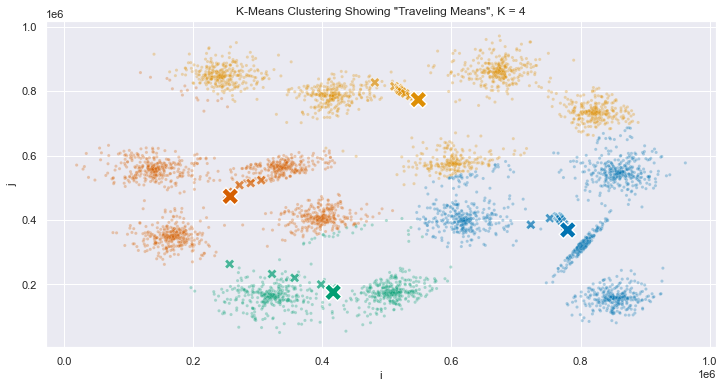

In [90]:
# implementation and visualization using synthetic dataset from class and k = 4

sdata,sm,smpath = mykmeans(synthetic,4)
plt.figure(figsize=(12,6))

g = sns.scatterplot(data=sdata,x='i',y='j',hue='assignments',alpha=0.3,s=10,palette='colorblind')
g = sns.scatterplot(data=smpath,x='i',y='j',hue='assignments',marker='X',s=100,alpha=0.7,palette='colorblind')
g = sns.scatterplot(data=sm,x='i',y='j',hue='assignments',marker='X',s=300,color='r',palette='colorblind')
g.legend_.remove()
g.set_title('K-Means Clustering Showing "Traveling Means", K = 4')



Below, I apply the algorithm to the class data with the specified 15 clusters. 
I did not plot the trails for clearer visuals.
I noticed that the groups are not always ideally labeled, since centroids calculated from initially randomly picked points. 

Text(0.5, 1.0, 'K-Means Clustering With K=15')

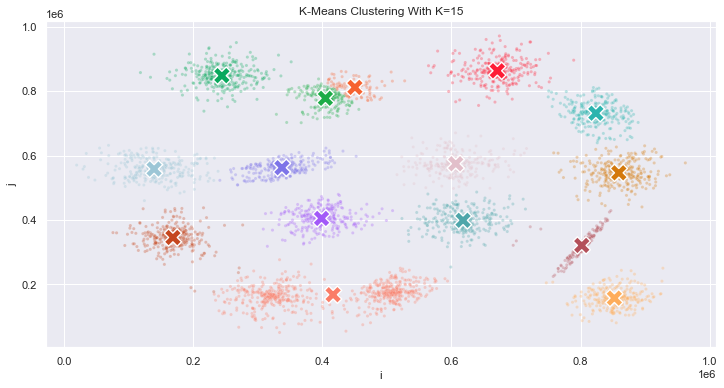

In [107]:
colors = sns.color_palette(["#D4790C", '#7D74E8','#A259F8','#09A85D',\
                           '#C5461E','#4EA6AA','#B3505A','#2AB4AE',\
                           '#FA7D68','#FE1D36','#1CAC47','#F66230',\
                           '#9CC6D6','#E2BFCA','#FEAD5B'])


sdata,sm,smpath = mykmeans(synthetic,15)
plt.figure(figsize=(12,6))

g = sns.scatterplot(data=sdata,x='i',y='j',hue='assignments',alpha=0.3,s=10,palette=colors)
g = sns.scatterplot(data=sm,x='i',y='j',hue='assignments',marker='X',s=300,palette=colors)
g.legend_.remove()
g.set_title('K-Means Clustering With K=15')


The algorithm works dynamically for any N dimensions. Below, I apply it to the 5-dimensional thyroid data set.

In [109]:
tdata,tm,tpath = mykmeans(thyroid,5)
tdata

,a,b,c,d,e,assignments
0,3195023,3455331,3497964,3068822,3206710,3
1,3651455,3412754,4131996,3248619,3603214,0
2,4716462,4051411,3638860,3150548,2946503,0
3,3347167,2433481,3075276,3150548,3058020,2
4,3042879,2859252,3004828,3166893,2859768,3
...,...,...,...,...,...,...
210,4031814,2688944,2863932,3199583,4297098,2
211,5629326,2199307,2441244,3624557,3652778,2
212,2890735,2390904,2934380,3117858,3491697,2
213,2434303,2305750,2723036,3264964,4433397,2


## Part 4: Assessing quality
In the next part I calculate the quality of the clustering algorithms using the Davies-Boulder and Dunn indices. I used sklearn's built in DB score, and construct helper functions for the Dunn score. I also plot the indicies for the thyroid dataset for a set of K values to determine the ideal K for each index/score.

Here is the DB score for synthetic data K-means with k=15:

In [93]:
print('Davies-Bouldin Score for K = 15: ',davies_bouldin_score(sdata[['i','j']], sdata.assignments))

Davies-Bouldin Score for K = 15:  0.8264476971581562


And here is a graph of DB scores for the thyroid data set, with ks ranging from 2 to 30:

Running Davies-Bouldin score calculations
Best score is with 7 clusters :0.8694767723812292


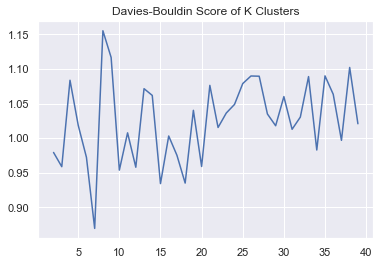

In [102]:
# Plot davies-bouldin scores for thyroid data set, k in range of 2 to 30 clusters

from sklearn.metrics import davies_bouldin_score

print('Running Davies-Bouldin score calculations')
scores = []
k = []
for n in range(2,40):
    tdata,tm,tpath = mykmeans(thyroid,n)
    k.append(n)
    score = davies_bouldin_score(tdata[['a','b','c','d','e']], tdata.assignments)
    scores.append(score)

sns.lineplot(x=k,y=scores).set_title('Davies-Bouldin Score of K Clusters')

print(f'Best score is with {k[scores.index(min(scores))]} clusters :{min(scores)}')


Below I define the Dunn index, since the sklearn package is out of data. 
Source: https://ruivieira.dev/micro/8/

In [97]:
# define dunn index since sklearn package is out of date

def δ(ck, cl):
    values = np.ones([len(ck), len(cl)])
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)

def Δ(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)

def dunn(k_list):
    δs = np.ones([len(k_list), len(k_list)])
    Δs = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            δs[k, l] = δ(k_list[k], k_list[l])
        
        Δs[k] = Δ(k_list[k])

    di = np.min(δs)/np.max(Δs)
    return di


I also defined a helped function to modularize the application of the index to a run of my kmeans algorithm:

In [85]:
def get_dunn(d,k):
    tdata,tm,tpath = mykmeans(d,k)
    k_list = []
    for i in tdata.assignments.unique().tolist():
        k_list.append(tdata[tdata.assignments == i].values)
    return dunn(k_list) 


Finally, I ran the Dunn score on the kmeans algorithm using the thyroid data set for Ks ranging from 2 to 40, and on the synthetic data set for K=15. A problem I saw with the Dunn score is that it does not include clusters of 1 as part of the score, so there could be a lot of single points that would not be considered part of any cluster in the index. I had to only include the categories with more than one data point.

Running Dunn Score calculations: 
9.292668852348128e-08
1.1803602676750931e-07
1.1803602676750931e-07
1.2175122317496207e-07
1.1803602676750931e-07
1.1803602676750931e-07
2.1142101616051754e-07
1.1803602676750931e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.134368945974349e-07
3.0097360883319935e-07
2.482578586612535e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
1.6111301417066845e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
1.6111301417066845e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
3.615756399554212e-07
3.0685812497945464e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
2.2601262975935893e-07
3.0685812497945464e-07
2.2601262975935893e-07
2.2601262975935893e-07
Best score is with 30 clusters :3.615756399554212e-07


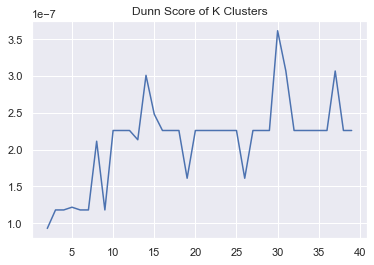

In [103]:
scores = []
k = []
print('Running Dunn Score calculations: ')
for n in range(2,40):
    score = get_dunn(thyroid,n)
    scores.append(score)
    
sns.lineplot(x=k,y=scores).set_title('Dunn Score of K Clusters')
print(f'Best score is with {k[scores.index(max(scores))]} clusters :{max(scores)}')


In [104]:
# Dunn score for synthetic data set:

get_dunn(synthetic,15)

2.7360466536287185e-06